# Home Credit Default Risk 6


## Feature Selection

Kaggle Question:

https://www.kaggle.com/c/home-credit-default-risk/data

This work is to further explore home credit default risk following:

https://github.com/dongzhang84/Kaggle/blob/master/Home%20Credit%20Default%20Risk/Home_Credit_1.ipynb

https://github.com/dongzhang84/Kaggle/blob/master/Home%20Credit%20Default%20Risk/Home_Credit_2.ipynb

https://github.com/dongzhang84/Kaggle/blob/master/Home%20Credit%20Default%20Risk/Home_Credit_3.ipynb

https://github.com/dongzhang84/Kaggle/blob/master/Home%20Credit%20Default%20Risk/Home_Credit_4.ipynb

https://github.com/dongzhang84/Kaggle/blob/master/Home%20Credit%20Default%20Risk/Home_Credit_5.ipynb

Reference: 

https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection

In [1]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# featuretools for automated feature engineering
import featuretools as ft

# matplotlit and seaborn for visualizations
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

# modeling 
import lightgbm as lgb

# utilities
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

# memory management
import gc

In [3]:
ls data

HomeCredit_columns_description.csv* previous_application.csv*
POS_CASH_balance.csv*               sample_submission.csv*
application_test.csv*               test_bureau_corrs_removed.csv
application_train.csv*              test_bureau_raw.csv
bureau.csv*                         test_previous_raw.csv
bureau_balance.csv*                 train_bureau_corrs_removed.csv
credit_card_balance.csv*            train_bureau_raw.csv
installments_payments.csv*          train_previous_raw.csv


In [27]:
# Read in data
#train_bureau = pd.read_csv('data/train_bureau_raw.csv', nrows = 1000)
#test_bureau = pd.read_csv('data/test_bureau_raw.csv', nrows = 1000)

#train_previous = pd.read_csv('data/train_previous_raw.csv', nrows = 1000)
#test_previous = pd.read_csv('data/test_previous_raw.csv', nrows = 1000)


train_bureau = pd.read_csv('data/train_bureau_raw.csv')
test_bureau = pd.read_csv('data/test_bureau_raw.csv')

train_previous = pd.read_csv('data/train_previous_raw.csv')
test_previous = pd.read_csv('data/test_previous_raw.csv')

# All columns in dataframes
bureau_columns = list(train_bureau.columns)
previous_columns = list(train_previous.columns)

In [28]:
len(bureau_columns)

333

In [29]:
len(previous_columns)

1514

In [30]:
# Bureau only features
bureau_features = list(set(bureau_columns) - set(previous_columns))

# Previous only features
previous_features = list(set(previous_columns) - set(bureau_columns))

# Original features will be in both datasets
original_features = list(set(previous_columns) & set(bureau_columns))

print('There are %d original features.' % len(original_features))
print('There are %d bureau and bureau balance features.' % len(bureau_features))
print('There are %d previous Home Credit loan features.' % len(previous_features))

There are 122 original features.
There are 211 bureau and bureau balance features.
There are 1392 previous Home Credit loan features.


In [31]:
len(previous_features)

1392

In [32]:
train_labels = train_bureau['TARGET']
previous_features.append('SK_ID_CURR')

train_ids = train_bureau['SK_ID_CURR']
test_ids = test_bureau['SK_ID_CURR']

In [33]:
# Merge the dataframes avoiding duplicating columns by subsetting train_previous

df_train = train_bureau.merge(train_previous[previous_features], on = 'SK_ID_CURR')
df_test = test_bureau.merge(test_previous[previous_features], on = 'SK_ID_CURR')

print('Training shape: ', df_train.shape)
print('Testing shape: ', df_test.shape)

Training shape:  (307511, 1725)
Testing shape:  (48744, 1724)


In [34]:
# One hot encoding

df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

# Match the columns in the dataframes
df_train, df_test = df_train.align(df_test, join = 'inner', axis = 1)

print('Training shape: ', df_train.shape)
print('Testing shape: ', df_test.shape)

Training shape:  (307511, 1845)
Testing shape:  (48744, 1845)


# Remove Collinear Variables

In [35]:
# Threshold for removing correlated variables

threshold = 0.9

# Absolute value correlation matrix
corr_matrix = df_train.corr().abs()
corr_matrix.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
SK_ID_CURR,1.000000,0.001129,0.001820,0.000343,0.000433,0.000232,0.000849,0.001500,0.001366,0.000973,...,0.000553,0.002073,0.000976,0.000072,0.001396,0.002300,0.001281,0.000270,0.000510,0.002549
CNT_CHILDREN,0.001129,1.000000,0.012882,0.002145,0.021374,0.001827,0.025573,0.330938,0.239818,0.183395,...,0.001830,0.005272,0.000709,0.001607,0.002032,0.020892,0.025088,0.011036,0.038644,0.004525
AMT_INCOME_TOTAL,0.001820,0.012882,1.000000,0.156870,0.191657,0.159610,0.074796,0.027261,0.064223,0.027805,...,0.000718,0.011696,0.006149,0.023886,0.003886,0.032753,0.016523,0.003369,0.050174,0.002894
AMT_CREDIT,0.000343,0.002145,0.156870,1.000000,0.770138,0.986968,0.099738,0.055436,0.066838,0.009621,...,0.000869,0.014314,0.007987,0.027255,0.005799,0.046644,0.009756,0.007373,0.058256,0.004308
AMT_ANNUITY,0.000433,0.021374,0.191657,0.770138,1.000000,0.775109,0.118429,0.009445,0.104332,0.038514,...,0.002166,0.015589,0.010077,0.035318,0.005968,0.054988,0.009189,0.007711,0.068145,0.003910


In [36]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
SK_ID_CURR,NaN,0.001129,0.001820,0.000343,0.000433,0.000232,0.000849,0.001500,0.001366,0.000973,...,0.000553,0.002073,0.000976,0.000072,0.001396,0.002300,0.001281,0.000270,0.000510,0.002549
CNT_CHILDREN,NaN,NaN,0.012882,0.002145,0.021374,0.001827,0.025573,0.330938,0.239818,0.183395,...,0.001830,0.005272,0.000709,0.001607,0.002032,0.020892,0.025088,0.011036,0.038644,0.004525
AMT_INCOME_TOTAL,NaN,NaN,NaN,0.156870,0.191657,0.159610,0.074796,0.027261,0.064223,0.027805,...,0.000718,0.011696,0.006149,0.023886,0.003886,0.032753,0.016523,0.003369,0.050174,0.002894
AMT_CREDIT,NaN,NaN,NaN,NaN,0.770138,0.986968,0.099738,0.055436,0.066838,0.009621,...,0.000869,0.014314,0.007987,0.027255,0.005799,0.046644,0.009756,0.007373,0.058256,0.004308
AMT_ANNUITY,NaN,NaN,NaN,NaN,NaN,0.775109,0.118429,0.009445,0.104332,0.038514,...,0.002166,0.015589,0.010077,0.035318,0.005968,0.054988,0.009189,0.007711,0.068145,0.003910


In [37]:
# Select columns with correlations above threshold

to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 986 columns to remove.


In [38]:
df_train = df_train.drop(columns = to_drop)
df_test = df_test.drop(columns = to_drop)

print('Training shape: ', df_train.shape)
print('Testing shape: ', df_test.shape)

Training shape:  (307511, 859)
Testing shape:  (48744, 859)


In [39]:
df_train.to_csv('data/m_train_combined.csv', index=False)
df_test.to_csv('data/m_test_combined.csv', index=False)

# Remove Missing Values

In [41]:
# Train missing values (in percent)
train_missing = (df_train.isnull().sum() / len(df_train)).sort_values(ascending = False)
train_missing.head()

client_credit_AMT_PAYMENT_CURRENT_max_mean_y         0.801438
client_credit_AMT_PAYMENT_CURRENT_min_max_x          0.801438
client_credit_AMT_PAYMENT_CURRENT_mean_mean_y        0.801438
client_credit_CNT_DRAWINGS_POS_CURRENT_mean_max_x    0.801178
client_credit_AMT_DRAWINGS_POS_CURRENT_min_mean_x    0.801178
dtype: float64

In [42]:
# Test missing values (in percent)
test_missing = (df_test.isnull().sum() / len(df_test)).sort_values(ascending = False)
test_missing.head()

client_credit_CNT_DRAWINGS_ATM_CURRENT_mean_max_x    0.773223
client_credit_CNT_DRAWINGS_POS_CURRENT_min_min_x     0.773223
client_credit_CNT_DRAWINGS_ATM_CURRENT_min_min_y     0.773223
client_credit_AMT_DRAWINGS_POS_CURRENT_mean_min_x    0.773223
client_credit_CNT_DRAWINGS_POS_CURRENT_max_max_x     0.773223
dtype: float64

In [43]:
# Identify missing values above threshold

train_missing = train_missing.index[train_missing > 0.75]
test_missing = test_missing.index[test_missing > 0.75]

all_missing = list(set(set(train_missing) | set(test_missing)))
print('There are %d columns with more than 75%% missing values' % len(all_missing))

There are 20 columns with more than 75% missing values


In [51]:
# Need to save the labels because aligning will remove this column

train_labels = train_labels
train_ids = df_train['SK_ID_CURR']
test_ids = df_test['SK_ID_CURR']

df_train = pd.get_dummies(df_train.drop(columns = all_missing))
df_test = pd.get_dummies(df_test.drop(columns = all_missing))

df_train, df_test = df_train.align(df_test, join = 'inner', axis = 1)

print('Training set full shape: ', df_train.shape)
print('Testing set full shape: ' , df_test.shape)

Training set full shape:  (307511, 839)
Testing set full shape:  (48744, 839)


In [50]:
train_labels.shape

(307511,)

In [52]:
df_train = df_train.drop(columns = ['SK_ID_CURR'])
df_test = df_test.drop(columns = ['SK_ID_CURR'])

In [53]:
df_train.shape

(307511, 838)

# Feature Selection through Feature Importances

In [55]:
# Initialize an empty array to hold feature importances
feature_importances = np.zeros(df_train.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', 
                           n_estimators = 10000, class_weight = 'balanced')

In [58]:
df_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in df_train.columns]

In [66]:
df_test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in df_test.columns]

In [59]:
# Fit the model twice to avoid overfitting

for i in range(2):
    
    # Split into training and validation set
    train_features, valid_features, train_y, valid_y \
          = train_test_split(df_train, train_labels, test_size = 0.25, random_state = i)
    
    # Train using early stopping
    model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
              eval_metric = 'auc', verbose = 200)
    
    # Record the feature importances
    feature_importances += model.feature_importances_

Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.780352	valid_0's binary_logloss: 0.5096
Early stopping, best iteration is:
[168]	valid_0's auc: 0.78109	valid_0's binary_logloss: 0.517405
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.782784	valid_0's binary_logloss: 0.50862
Early stopping, best iteration is:
[157]	valid_0's auc: 0.783923	valid_0's binary_logloss: 0.518568


In [61]:
# Make sure to average feature importances! 

feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(df_train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances.head()

,feature,importance
24,EXT_SOURCE_1,81.50
25,EXT_SOURCE_2,70.50
26,EXT_SOURCE_3,63.25
5,DAYS_BIRTH,53.00
496,client_installments_AMT_PAYMENT_min_sum,48.25


In [62]:
# Find the features with zero importance

zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()

There are 286 features with 0.0 importance


,feature,importance
274,client_credit_AMT_DRAWINGS_ATM_CURRENT_min_sum_y,0.0
278,df_previous_NAME_CASH_LOAN_PURPOSE_Buying_a_ne...,0.0
280,df_previous_NAME_CLIENT_TYPE_XNA_mean,0.0
283,df_previous_NAME_PAYMENT_TYPE_Non_cash_from_yo...,0.0
837,EMERGENCYSTATE_MODE_Yes,0.0


In [63]:
def plot_feature_importances(df, threshold = 0.9):
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

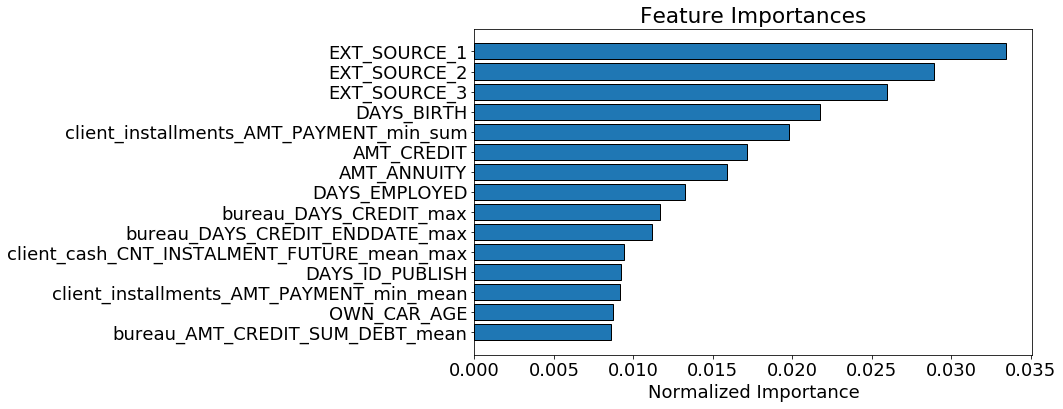

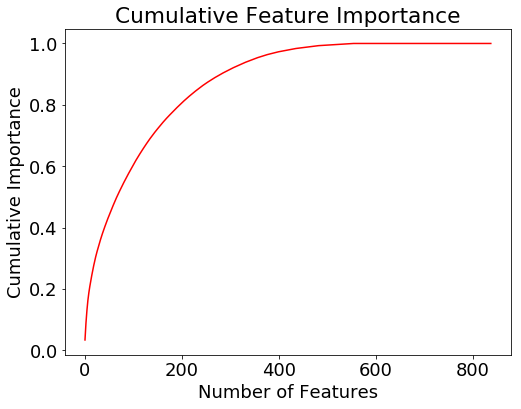

282 features required for 0.90 of cumulative importance


In [64]:
norm_feature_importances = plot_feature_importances(feature_importances)

In [68]:
#df_train = df_train.drop(columns = zero_features)
df_test = df_test.drop(columns = zero_features)

print('Training shape: ', df_train.shape)
print('Testing shape: ', df_test.shape)

Training shape:  (307511, 552)
Testing shape:  (48744, 552)


In [72]:
def identify_zero_importance_features(train, train_labels, iterations = 2):
    
    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(train.shape[1])

    # Create the model with several hyperparameters
    model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, 
                               class_weight = 'balanced')
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):

        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)

        # Train using early stopping
        model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
                  eval_metric = 'auc', verbose = 200)

        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations
        
    feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))
    
    return zero_features, feature_importances

In [73]:
second_round_zero_features, feature_importances = identify_zero_importance_features(df_train, train_labels)

Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.781048	valid_0's binary_logloss: 0.509174
Early stopping, best iteration is:
[189]	valid_0's auc: 0.781217	valid_0's binary_logloss: 0.511646
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.783884	valid_0's binary_logloss: 0.507606
Early stopping, best iteration is:
[179]	valid_0's auc: 0.784143	valid_0's binary_logloss: 0.513038

There are 0 features with 0.0 importance


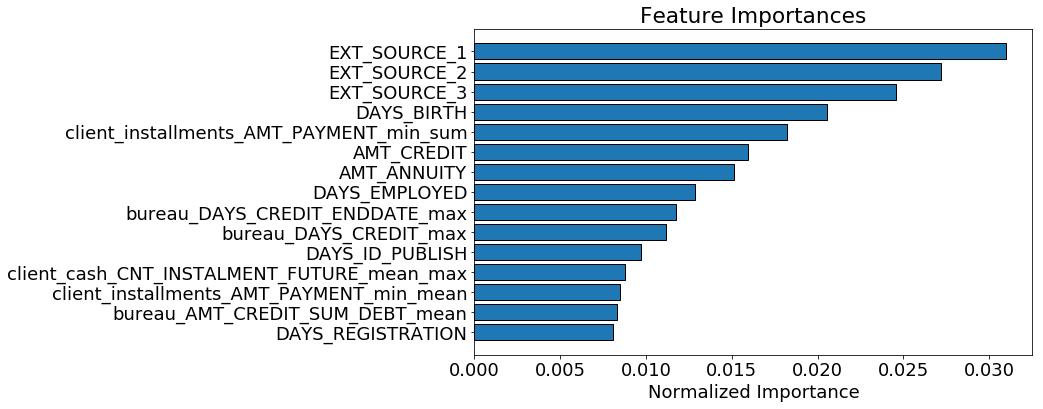

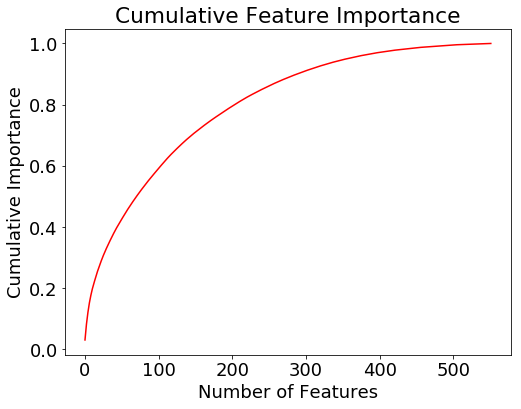

357 features required for 0.95 of cumulative importance


In [74]:
norm_feature_importances = plot_feature_importances(feature_importances, threshold = 0.95)

In [75]:
# Threshold for cumulative importance

threshold = 0.95

# Extract the features to keep

features_to_keep = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] < threshold]['feature'])

# Create new datasets with smaller features
df_train_small = df_train[features_to_keep]
df_test_small = df_test[features_to_keep]

In [76]:
df_train_small['TARGET'] = train_labels
df_train_small['SK_ID_CURR'] = train_ids
df_test_small['SK_ID_CURR'] = test_ids

#train_small.to_csv('m_train_small.csv', index = False)
#test_small.to_csv('m_test_small.csv', index = False)

In [77]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    features = pd.get_dummies(features)
    test_features = pd.get_dummies(test_features)

    # Align the dataframes by the columns
    features, test_features = features.align(test_features, join = 'inner', axis = 1)

    # No categorical indices to record
    cat_indices = 'auto'
    
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    i = 0
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        print(i)
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
        i +=1
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [78]:
submission_small, feature_importances_small, metrics_small = model(df_train_small, df_test_small)

Training Data Shape:  (307511, 356)
Testing Data Shape:  (48744, 356)
0
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.829478	train's binary_logloss: 0.516045	valid's auc: 0.782565	valid's binary_logloss: 0.53525
[400]	train's auc: 0.865551	train's binary_logloss: 0.475728	valid's auc: 0.783553	valid's binary_logloss: 0.509877
Early stopping, best iteration is:
[371]	train's auc: 0.861265	train's binary_logloss: 0.480665	valid's auc: 0.783751	valid's binary_logloss: 0.513018
1
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.829324	train's binary_logloss: 0.516342	valid's auc: 0.784123	valid's binary_logloss: 0.536345
[400]	train's auc: 0.866078	train's binary_logloss: 0.47538	valid's auc: 0.785765	valid's binary_logloss: 0.51048
Early stopping, best iteration is:
[399]	train's auc: 0.865966	train's binary_logloss: 0.475513	valid's auc: 0.785779	valid's binary_logloss: 0.510558
2
Training until validation scores don'

In [79]:
metrics_small

,fold,train,valid
0,0,0.861265,0.783751
1,1,0.865966,0.785779
2,2,0.859460,0.778296
3,3,0.863884,0.784008
4,4,0.854478,0.783505
5,overall,0.861011,0.783057


In [80]:
submission_small.to_csv('selected_features_small_submission.csv', index = False)